<h1> <center> Study Project</center> </h1>
<h1> <center> Regression using Decision Tree and Random Forest </center> </h1>
<h3> <center> The case of a nonlinear problem </center> </h3>

- This is a study project that I’ve carried out to investigate how Decision Trees and Random Forests perform regressions, especially for visualizing their nonlinear solutions. 
- My specific aim was to visualize the regressions by plotting the solution space of the models given the range of values that the predicting variables can assume. 
- To this end, I’ve chosen a simple dataset from Kaggle consisting of students’ marks that should be predicted by number of courses attended and study time.
- My modelling approach comprised 4 models: a baseline “Mean Model”, a Linear Regression, a Decision Tree Regression, and a Random Forest Regression.
- The models’ performances were assessed using a validation subset, that is, data “unknown” to the models during the training. The absolute distance from each prediction to the real value were computed - the mean of these errors are then computed. This is known as the Mean Absolute Error (MAE), which indicates how much the predictions deviated in average from the real values.
- I’ve created static 3D plots as well as dynamic 3D plots showing the 360<sup>o</sup> rotation of the models’ solutions.

The Dataset:<br>
https://www.kaggle.com/datasets/yasserh/student-marks-dataset/

| column | description
| --- | --- | 
| number_courses | number of courses attended
| time_study | study time
| Marks | student's mark

The objetive is to predict the students’ marks based on the number of courses and study time.

## Libraries

Here, we load all the libraries used in this project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import warnings # For disabling a warning message from dtreeviz
import graphviz
from dtreeviz.trees import dtreeviz 
from IPython.display import SVG

## General configurations

Here, we set general configurations regarding the quality of plots.

In [2]:
# Image settings for higher quality
%config InlineBackend.figure_formats = ['svg']
# For plotting editable 3D plot
%matplotlib notebook

## Data

Here, we load the dataset. It has 100 observations and 3 variables.

In [3]:
df = pd.read_csv('Student_Marks.csv')
print('Shape:', df.shape)
display( df.head() )

Shape: (100, 3)


number_courses  time_study   Marks
0               3       4.508  19.202
1               4       0.096   7.734
2               4       3.133  13.811
3               6       7.909  53.018
4               8       7.811  55.299

### Data consistency

Here, we see that the dataset is consistent: the data types are correct and there are no missing values or duplicated data.

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   number_courses  100 non-null    int64  
 1   time_study      100 non-null    float64
 2   Marks           100 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 2.5 KB
None


In [5]:
n_duplicates = df.shape[0] - df.drop_duplicates().shape[0]
print(f'Number of duplicates: {n_duplicates}')

Number of duplicates: 0


## Descriptive statistics

### Univariate

In [6]:
display( df.describe().round(3).T )

count    mean     std    min     25%     50%     75%     max
number_courses  100.0   5.290   1.800  3.000   4.000   5.000   7.000   8.000
time_study      100.0   4.077   2.373  0.096   2.058   4.022   6.179   7.957
Marks           100.0  24.418  14.326  5.609  12.633  20.060  36.676  55.299

In [7]:
for col in df.columns:
    print(f'{col:>14}: ranged from {df[col].min()} to {df[col].max()}')

number_courses: ranged from 3 to 8
    time_study: ranged from 0.096 to 7.957
         Marks: ranged from 5.609 to 55.299


In [8]:
# Adjust normal plotting
%matplotlib auto

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


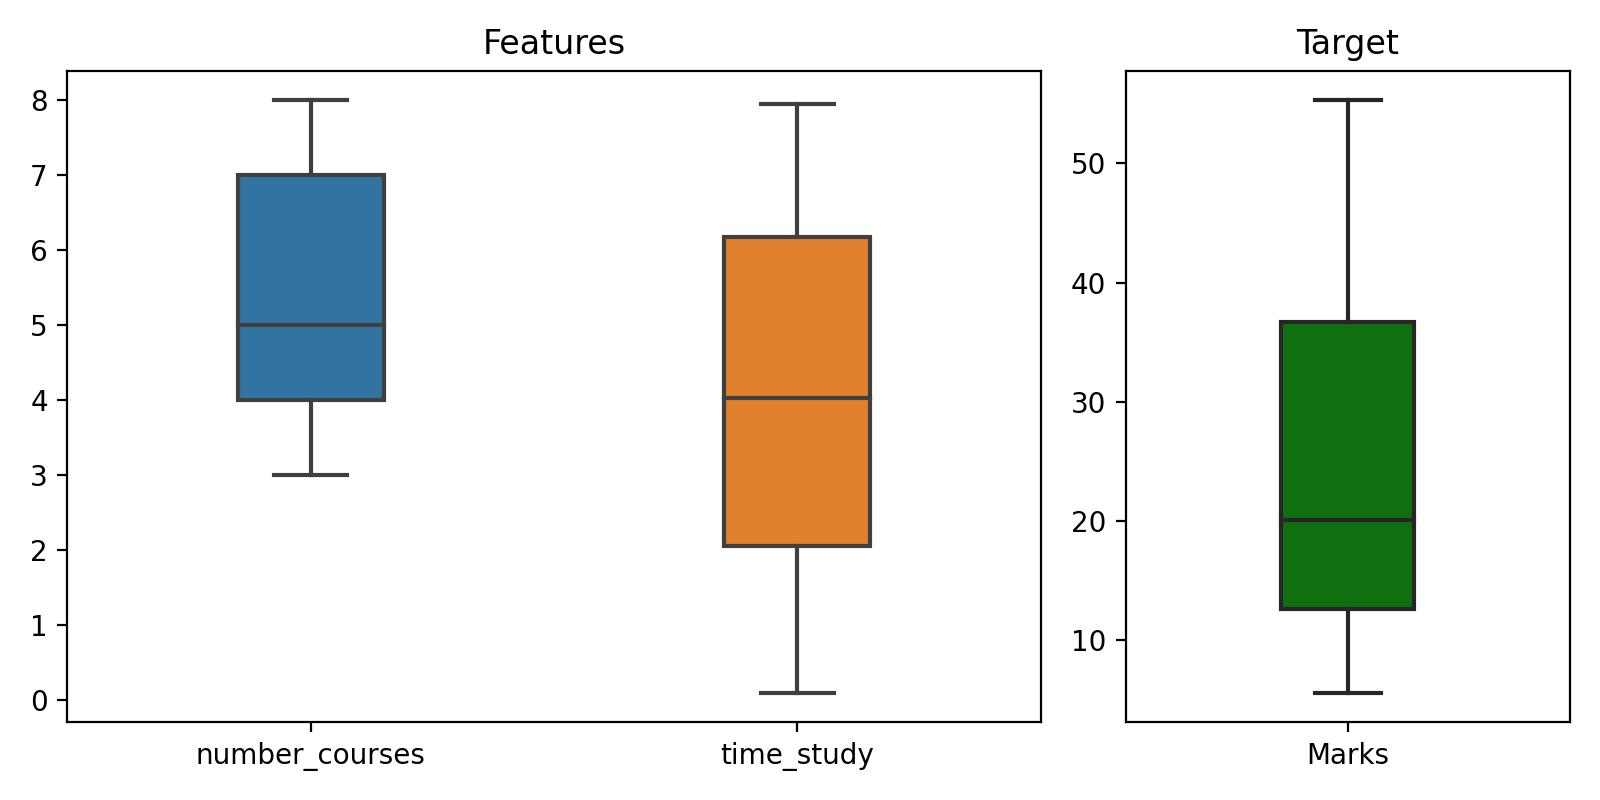

In [9]:
# Create a figure with 2 plots
fig = plt.figure(figsize=(8, 4))
specs = gridspec.GridSpec(nrows=1, ncols=3 , figure=fig)

ax1 = fig.add_subplot(specs[0, :2])
ax2 = fig.add_subplot(specs[0, 2])


# Plot 1
sns.boxplot(data=df[['number_courses','time_study']], width=0.3, ax=ax1)
ax1.set_title('Features')

# Plot 2
sns.boxplot(data=df[['Marks']], width=0.3, color='g', ax=ax2)
ax2.set_title('Target')

plt.tight_layout();

**Notes:**
- `number_courses` is a discrete variable
- `time_study` is a continuous variable
- `Marks` is a continuous variable 

### Bivariate

#### number_courses x Marks

<IPython.core.display.Javascript object>


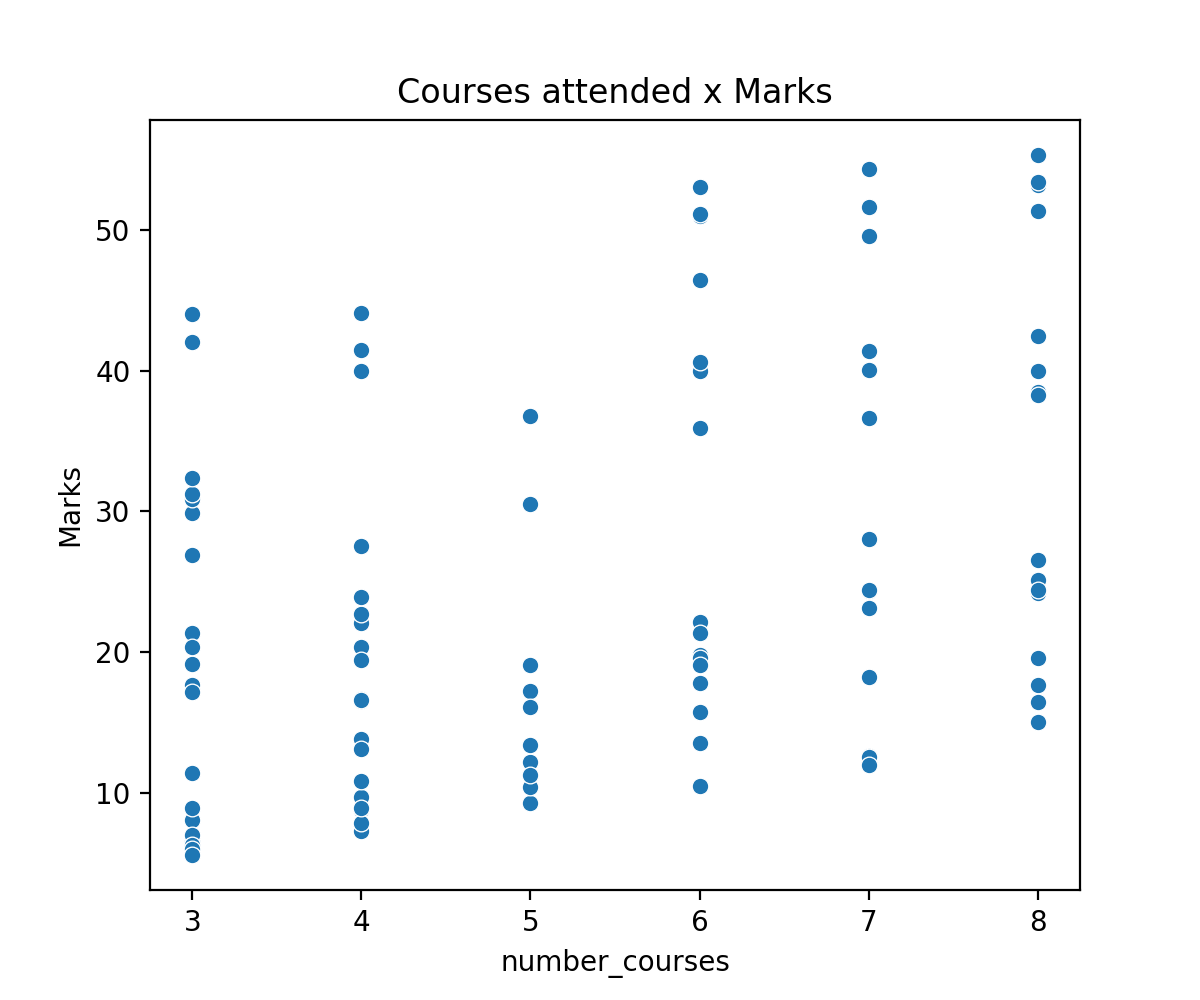

In [10]:
fig = plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x='number_courses', y='Marks')
plt.title('Courses attended x Marks')
plt.savefig('scatterplot1.png');

The standard scatter plot above, between the discrete variable 'number_courses' and the continuous variable 'Marks' is not much informative. The strip plot below use "jittering" (random noise) for best visualizing the overlapping data points.

In [11]:
# Create DF with the median Marks for each number_courses 
marks_per_ncourses = df[['number_courses', 'Marks']].groupby('number_courses').mean().reset_index()
marks_per_ncourses['number_courses'] = marks_per_ncourses['number_courses'].astype(str)

<IPython.core.display.Javascript object>


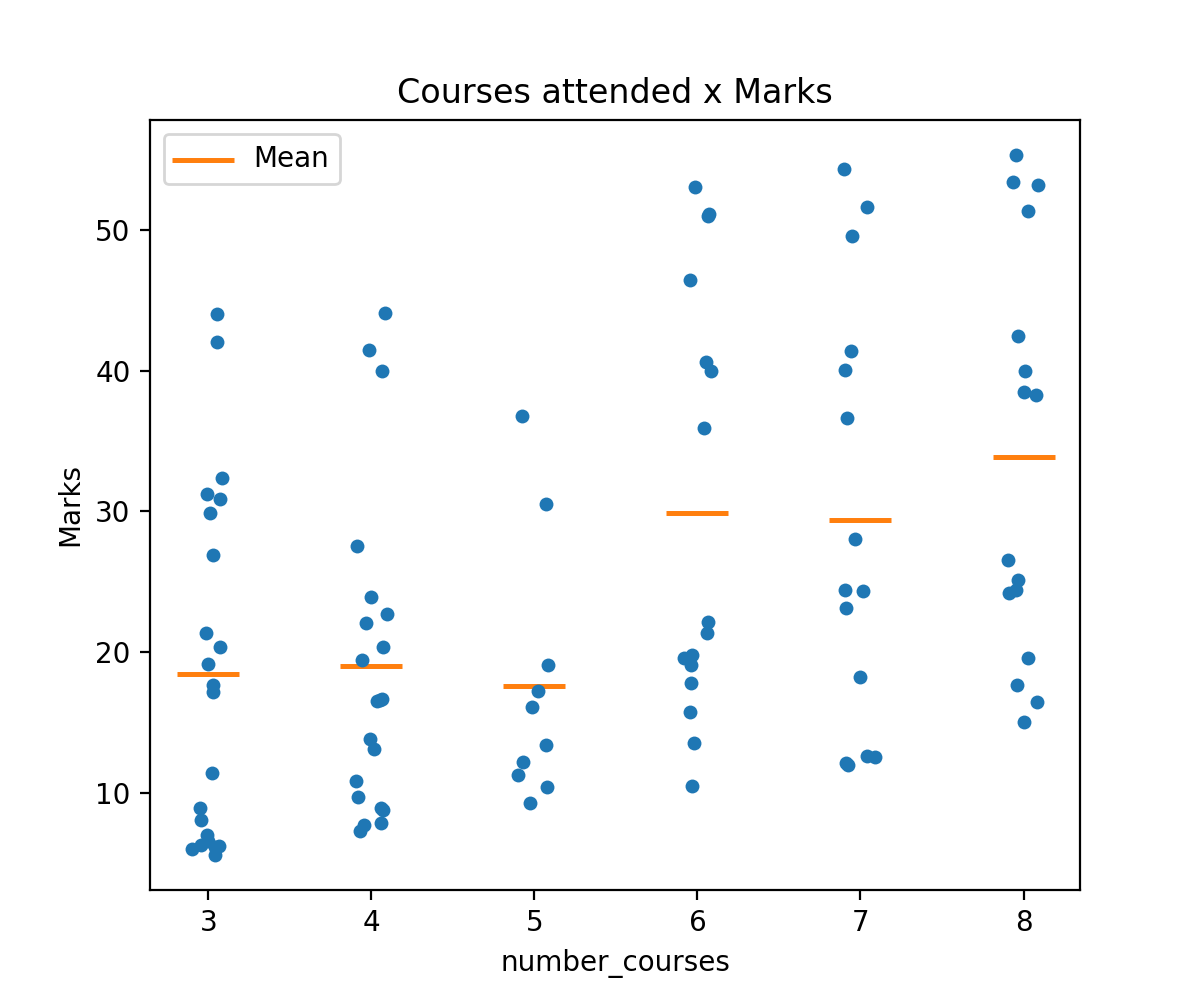

In [12]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.stripplot(data=df, x='number_courses', y='Marks', ax=ax)
sns.scatterplot(data=marks_per_ncourses, x='number_courses', y='Marks', 
                marker='_', s=500, ax=ax, label='Mean')

plt.legend()

plt.title('Courses attended x Marks')
plt.savefig('jitterplot.png');

In the plot above, we can observe two patterns: from number_courses 3 to 5, the mean Marks are around 19, whereas for number_courses 6 to 8 the mean Marks are around 30. 

#### time_study x Marks

In this plot, we can observe the nonlinear relationship between 'time_study' and 'Marks'.

<IPython.core.display.Javascript object>


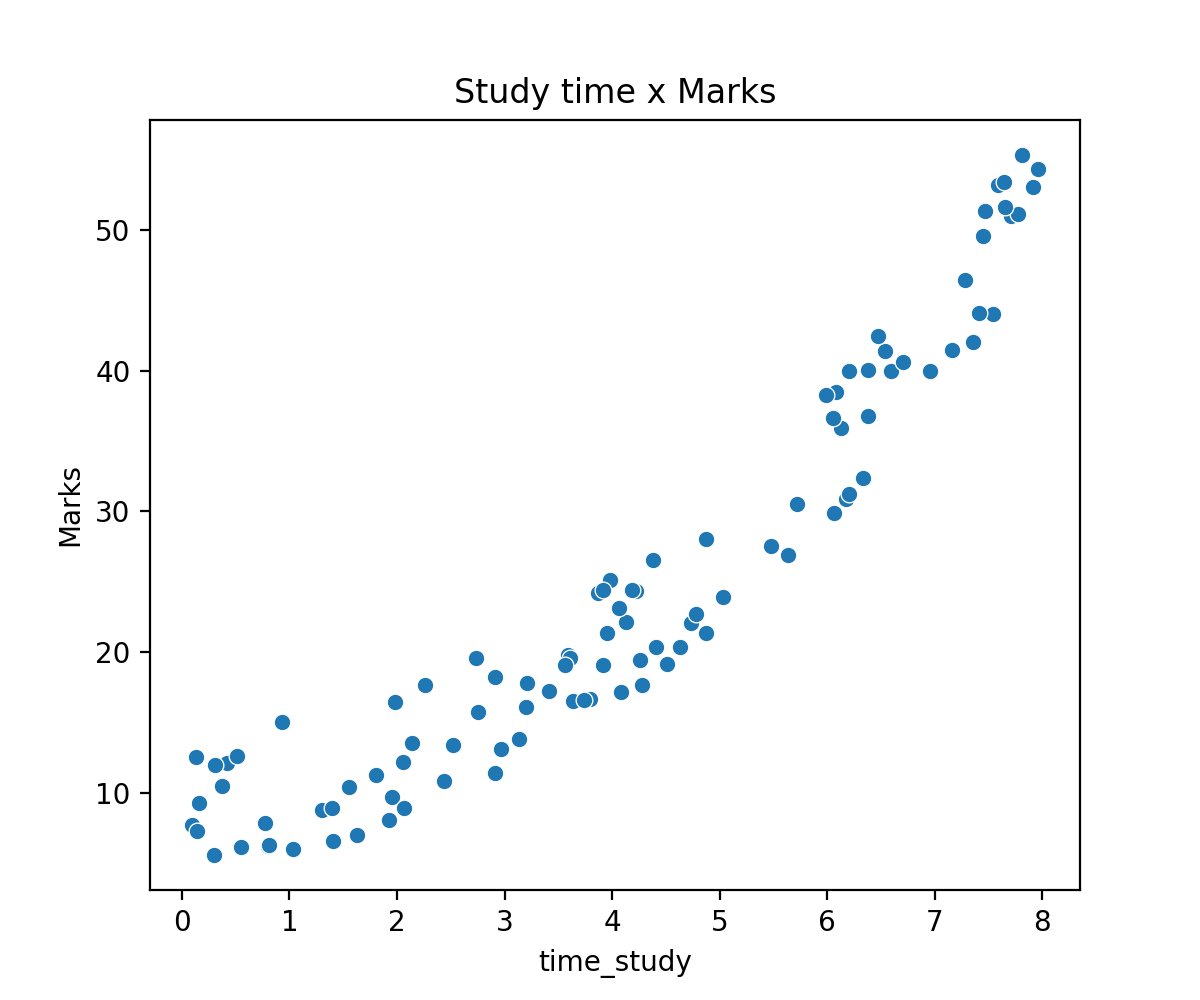

In [13]:
fig = plt.figure(figsize=(6, 5))
sns.scatterplot(data=df, x='time_study', y='Marks')
plt.title('Study time x Marks')
plt.savefig('scatterplot2.png');

### Multivariate

#### number_courses x time-study x Marks

In the three-dimensional plot below, we can observe the nonlinear distribution of data points. 

<IPython.core.display.Javascript object>


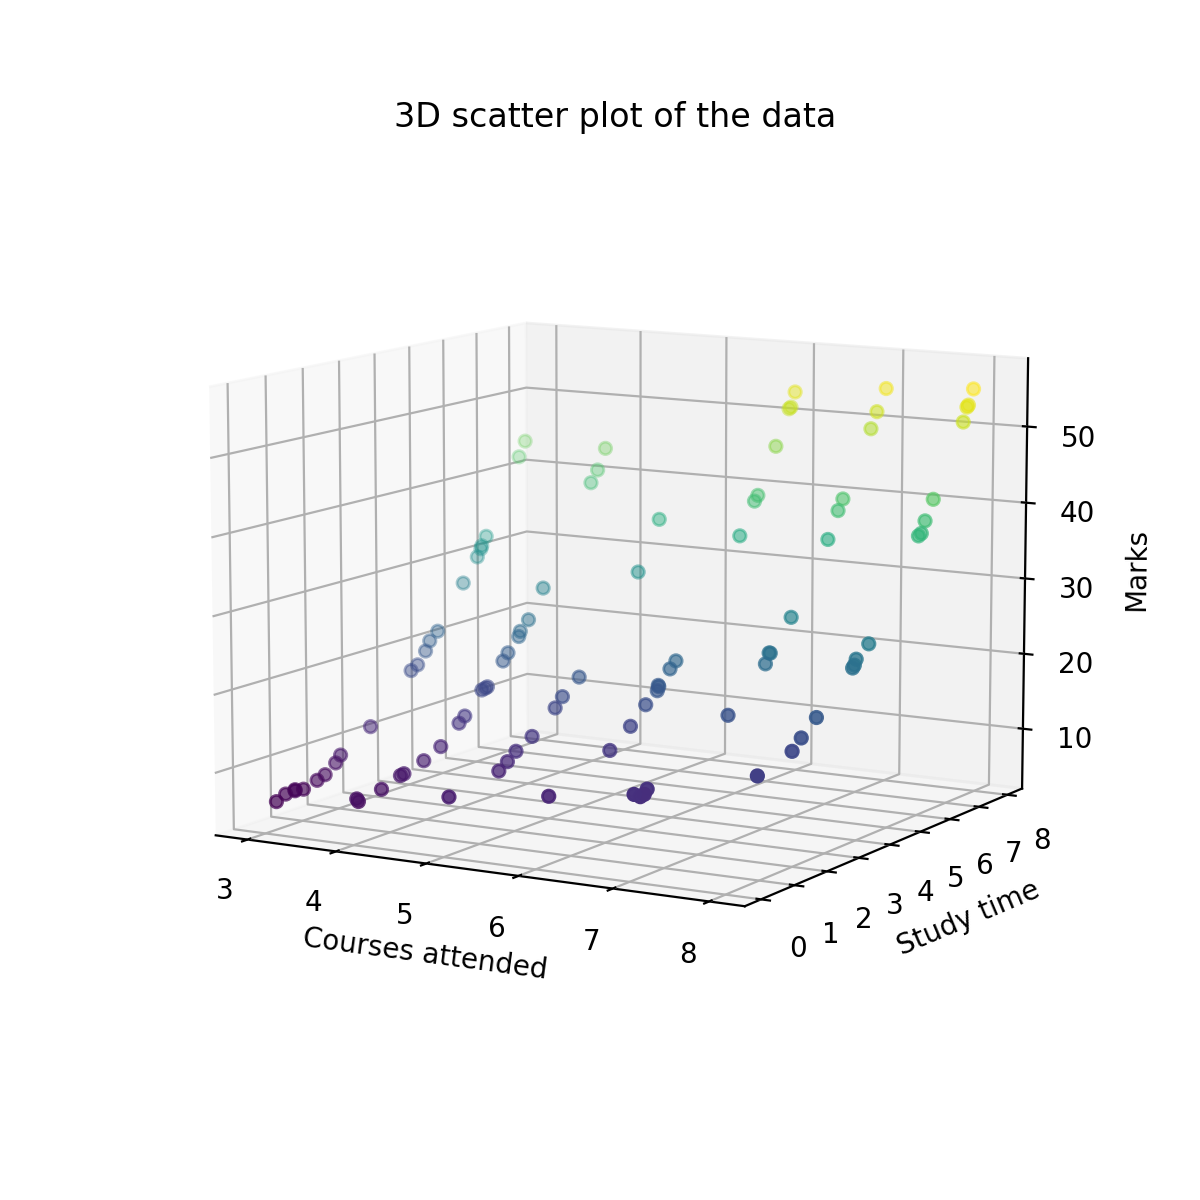

In [14]:
# For plotting editable 3D plot
%matplotlib notebook

# Create figure for 3D projection
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')

x1 = df['number_courses'] # x1: feature 1
x2 = df['time_study']     # x2: feature 2
y = df['Marks']           # y:  target
ax.scatter(x1, x2, y, c=y) # plot

# Title and labels
ax.set_title('3D scatter plot of the data')
ax.set_xlabel("Courses attended")
ax.set_ylabel("Study time")
ax.set_zlabel("Marks")

# Set the angle of the camera
ax.view_init(10, 300)
plt.show()
plt.savefig('scatterplot3.png');

## Models

### Model planning

- The objective is to visualize the nonlinear regressions performed by Decision Tree and Random Forest Models. 
- The modelling approach comprised the development and comparison of four models: 
1. **Baseline “Mean Model”** to serve as a reference, which simply returns the mean Marks of the training set; 
2. **Linear Regression** to observe the shape of a linear fit of the data; 
3. **Decision Tree Model** 
4. **Random Forest Model** to observe nonlinear fits of the data. 

**Procedures:**<br>

- The dataset was splitted into **training and validation subsets**, that is, a random sample of 30% was separated for assessing the models performance with "unknown data" during the training.
- **Performance in validation** was assessed by the **Mean Absolute Error**, which indicates how much the predictions deviated in average from the real values.
- **Artificial data:** a set consisting of the combinatory between number_courses and time_study possible values was generated in order to plot the models predictions to these values. In this way, we visualize the solution space of the models. 

#### Table of the Mean Absolute Error of the models

In [15]:
models = ['Mean Model',
          'Linear Regression Model',
          'Decision Tree Model',
          'Random Forest Model']

cols = ['Error (Train)', 'Error (Validation)']

df_models = pd.DataFrame(np.zeros((len(models), len(cols))), 
                         index=models,
                         columns=cols)
display(df_models)

Error (Train)  Error (Validation)
Mean Model                         0.0                 0.0
Linear Regression Model            0.0                 0.0
Decision Tree Model                0.0                 0.0
Random Forest Model                0.0                 0.0

#### The train and validation sets

In [16]:
# Separating the Features and the Target
X = df[['number_courses', 'time_study']]
y = df['Marks']

In [17]:
# Splitting the dataset into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.3, random_state=13)

print('Train:',X_train.shape, y_train.shape)
print('Valid:',X_valid.shape, y_valid.shape)

Train: (70, 2) (70,)
Valid: (30, 2) (30,)


#### Table of the validation set and results

In [18]:
# Create a DF for the validation set and results
df_valid = pd.concat([X_valid, y_valid], axis=1)
display( df_valid.head(3) )

number_courses  time_study   Marks
37               6       7.283  46.453
62               6       3.606  19.590
83               5       3.197  16.106

#### Artificial data for displaying the models' predictions

Each possible discrete value of number_courses ("x1" from 3 to 8) was combined with 100 possible values of time_study ("x2" from 0.096 to 7.957), resulting in 600 combinations. This artificial dataset was submitted to the models in order to plot the predictions and visualize the models' behavior. 

In [19]:
# Create values for plotting the solution space of the models

# Generate a set of values for x1 and x2 coordinates
# x1 values range from 3 to 8
x1_values = np.arange(df['number_courses'].min(),df['number_courses'].max() + 1, 1) 
# 100 y values betwee min and max
x2_values = np.linspace(df['time_study'].min(), df['time_study'].max(), 100) 

# Combinatory between coordinates
x1_values, x2_values = np.meshgrid(x1_values, x2_values)
X_artif = np.array([x1_values.flatten(), x2_values.flatten()]).T

# Create a DF 
X_artif = pd.DataFrame(X_artif, columns=['number_courses', 'time_study'])

display( X_artif )

number_courses  time_study
0               3.0       0.096
1               4.0       0.096
2               5.0       0.096
3               6.0       0.096
4               7.0       0.096
..              ...         ...
595             4.0       7.957
596             5.0       7.957
597             6.0       7.957
598             7.0       7.957
599             8.0       7.957

[600 rows x 2 columns]

### Baseline Mean Model

In [20]:
# The mean model simply returns an array with the mean of the training set target
def mean_model(y_train, X_test):
    return np.array([y_train.mean()] * X_test.shape[0])

In [21]:
# Predictions for the validation set
df_valid['y_mean'] = mean_model(y_train, X_valid)

In [22]:
# Compute MAE - Train and Valid
mae_train_m_model = mean_absolute_error(y_train, mean_model(y_train, X_train))
mae_valid_m_model = mean_absolute_error(y_valid, df_valid['y_mean'])

# Log in the DF
df_models.loc['Mean Model', 'Error (Train)'] = mae_train_m_model
df_models.loc['Mean Model', 'Error (Validation)'] = mae_valid_m_model

display( df_models.iloc[:1] )

Error (Train)  Error (Validation)
Mean Model      11.353126           12.852542

In [23]:
# Predictions based on this model
predictions_m = mean_model(y_train, X_artif)

<IPython.core.display.Javascript object>


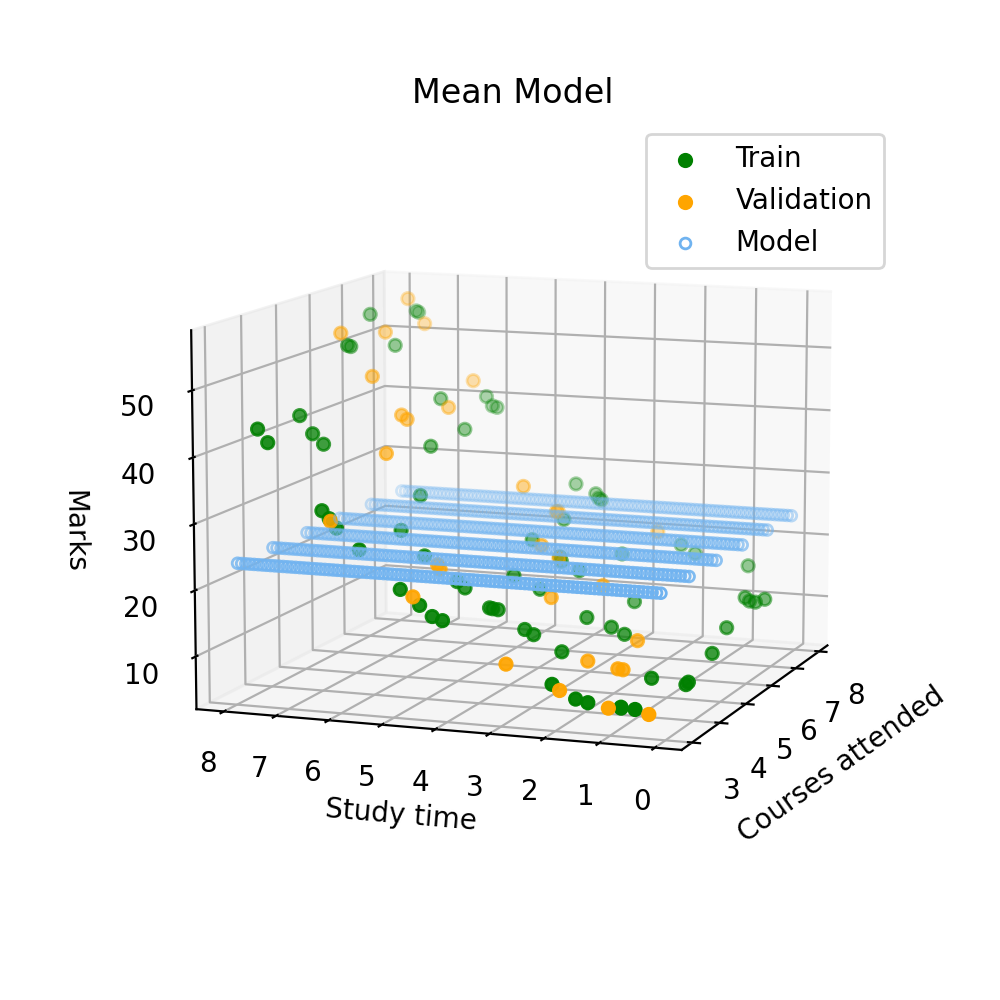

In [24]:
# Create figure for 3D projection
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection = '3d')

# Scatter plot of the training data
x1_t = X_train['number_courses'] # x1
x2_t = X_train['time_study']     # x2
y_t = y_train                    # y (target)
ax.scatter(x1_t, x2_t, y_t, c='green', label='Train')

# Scatter plot of the validation data
x1_v = X_valid['number_courses'] # x1
x2_v = X_valid['time_study']     # x2
y_v = y_valid                    # y (target)
ax.scatter(x1_v, x2_v, y_v, c='orange', label='Validation')

# Scatter plot of the artificial data
ax.scatter(X_artif['number_courses'], # x
           X_artif['time_study'],     # y
           predictions_m,               # z
           facecolor=(0,0,0,0), s=15, edgecolor='#70b3f0', label='Model')

# Set title and labels
ax.set_title('Mean Model')
ax.set_xlabel("Courses attended")
ax.set_ylabel("Study time")
ax.set_zlabel("Marks")

# Plot the legend
plt.legend()

# Set the angle of the camera
ax.view_init(10, 200)
plt.savefig('mean_model.png')
plt.ioff();

**Notes:** 
- The training set data is in green color and the validation is in orange. In blue, we see the moldel's predictions to the artificial dataset. 
- As could have been expected, the Mean Model is a poor solution for predicting the students' Marks, given the distribution pattern of the data. Nevertheless, it provides a reference for evaluating the other models. 
- In average, this model deviated 12.85 points from the Marks observed in the validation set.

### Linear Regression Model

In [25]:
# Create model and fit to the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Generate predictions based on validation data
df_valid['y_lr'] = lr_model.predict(X_valid)

In [26]:
# Compute MAE - Train and Valid
mae_train_lr_model = mean_absolute_error(y_train, lr_model.predict(X_train))
mae_valid_lr_model = mean_absolute_error(y_valid, df_valid['y_lr'])

# Log in the DF
df_models.loc['Linear Regression Model', 'Error (Train)'] = mae_train_lr_model
df_models.loc['Linear Regression Model', 'Error (Validation)'] = mae_valid_lr_model

# Compute the decrease % and display df_models
df_models['Valid. Error Decrease (%)'] = df_models['Error (Validation)'].pct_change() * 100
display( df_models.iloc[:2].round(2) )

Error (Train)  Error (Validation)  \
Mean Model                       11.35               12.85   
Linear Regression Model           3.19                2.73   

                         Valid. Error Decrease (%)  
Mean Model                                     NaN  
Linear Regression Model                     -78.75

In [27]:
# Generate predictions based on this model
predictions_lr = lr_model.predict(X_artif)

<IPython.core.display.Javascript object>


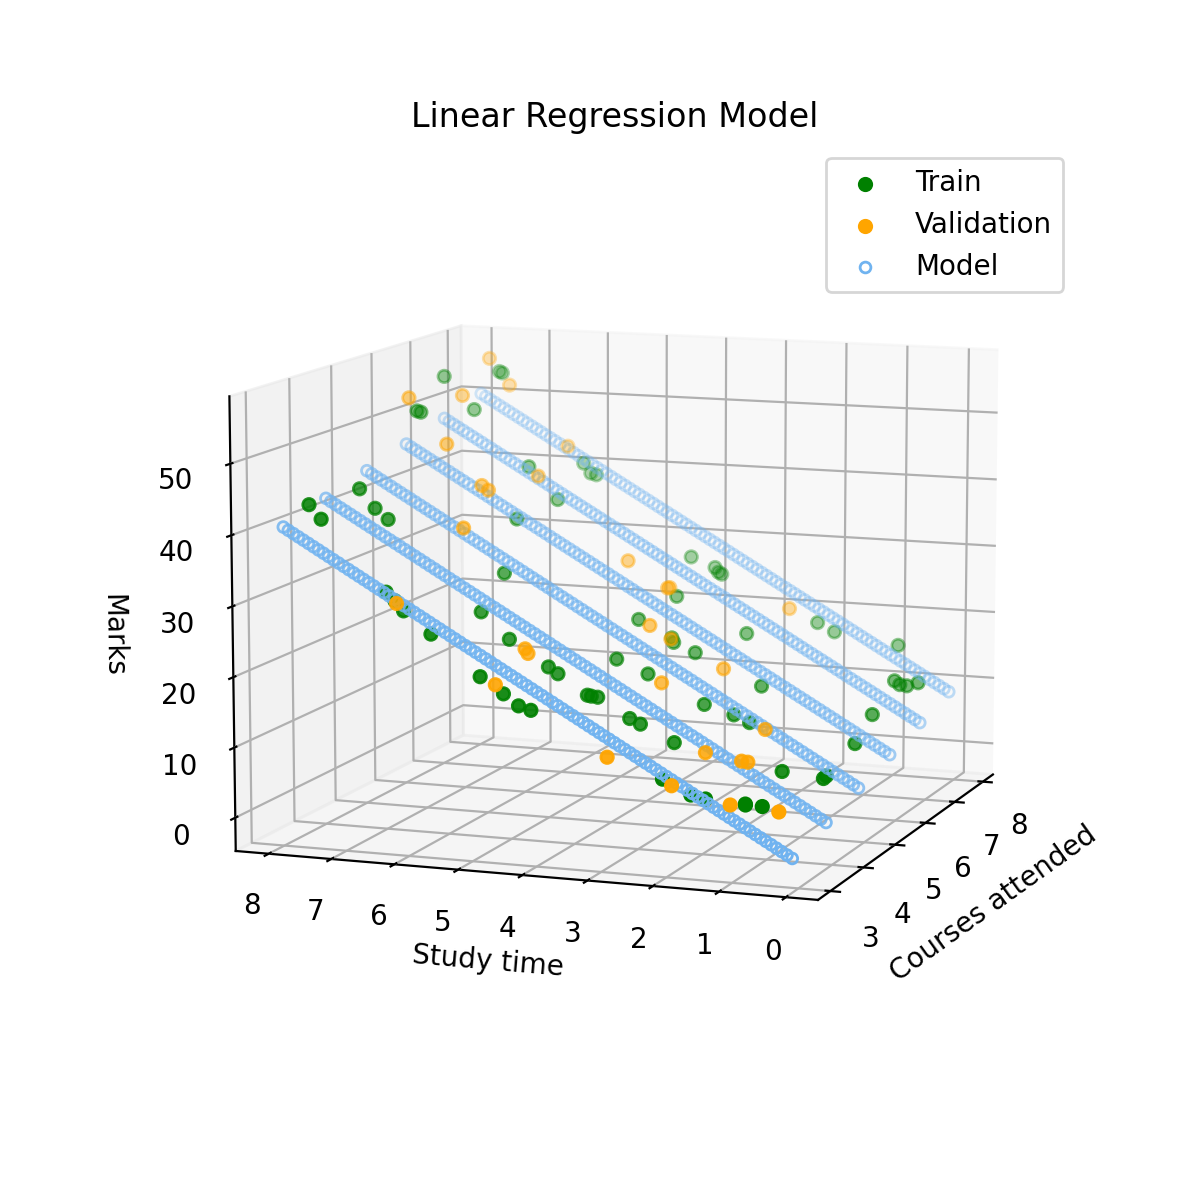

In [28]:
# For plotting editable 3D plot
%matplotlib notebook
plt.ion()
# Create figure for 3D projection
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')

# Scatter plot of the training data
x1_t = X_train['number_courses'] # x1
x2_t = X_train['time_study']     # x2
y_t = y_train                    # y (target)
ax.scatter(x1_t, x2_t, y_t, c='green', label='Train')

# Scatter plot of the validation data
x1_v = X_valid['number_courses'] # x1
x2_v = X_valid['time_study']     # x2
y_v = y_valid                    # y (target)
ax.scatter(x1_v, x2_v, y_v, c='orange', label='Validation')

# Scatter plot of the artificial data
ax.scatter(X_artif['number_courses'], # x
           X_artif['time_study'],     # y
           predictions_lr,               # z
           facecolor=(0,0,0,0), s=15, edgecolor='#70b3f0', label='Model')

# Set title and labels
ax.set_title('Linear Regression Model')
ax.set_xlabel("Courses attended")
ax.set_ylabel("Study time")
ax.set_zlabel("Marks")

# Plot the legend
plt.legend()

# Set the angle of the camera
ax.view_init(10, 200)
plt.ioff();

**Notes:** 
- In blue, we see the model's predictions to the artificial dataset, providing a nice visualization of the model's behavior.
- This model clearly represented a better solution for predicting the students' Marks than the Mean Model.
- We can observe that it is able to capture some of the regularities of the data distribution - marks increase with study time and with the number of courses attended. Nevertheless, this model fails to capture the nonlinearity present in the data.
- In average, this model deviated 2.73 points from the Marks observed in the validation set.


See below the validation set observed Marks and the model's predictions.

In [29]:
# For plotting editable 3D plot
%matplotlib notebook
plt.ion()

# Create figure for 3D projection
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')


# Scatter plot of the validation data
x1_v = df_valid['number_courses'] # x1
x2_v = df_valid['time_study']     # x2
y_v = df_valid['Marks']           # y (target)
ax.scatter(x1_v, x2_v, y_v, c='orange', label='Observed')

# Scatter plot of the predicted data
ax.scatter(df_valid['number_courses'], # x
           df_valid['time_study'],     # y
           df_valid['y_lr'],           # z
           facecolor=(0,0,0,0), edgecolor='red', label='Predicted')

# Set title and labels
ax.set_title(f'Validation - Linear Regression\
\nMean Absolute Error: {mae_valid_lr_model:.2f}')
ax.set_xlabel("Courses attended")
ax.set_ylabel("Study time")
ax.set_zlabel("Marks")

# Plot the legend
plt.legend()

# Set the angle of the camera
ax.view_init(10, 190)
plt.ioff();

<IPython.core.display.Javascript object>

#### Model's coefficients

In [30]:
lr_coeficients = pd.DataFrame(lr_model.coef_, 
                              columns=['Coefficient'],
                              index=lr_model.feature_names_in_)
display( lr_coeficients )

Coefficient
number_courses     1.840659
time_study         5.254106

In [31]:
# Return to normal plotting
%matplotlib auto
plt.ion();

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


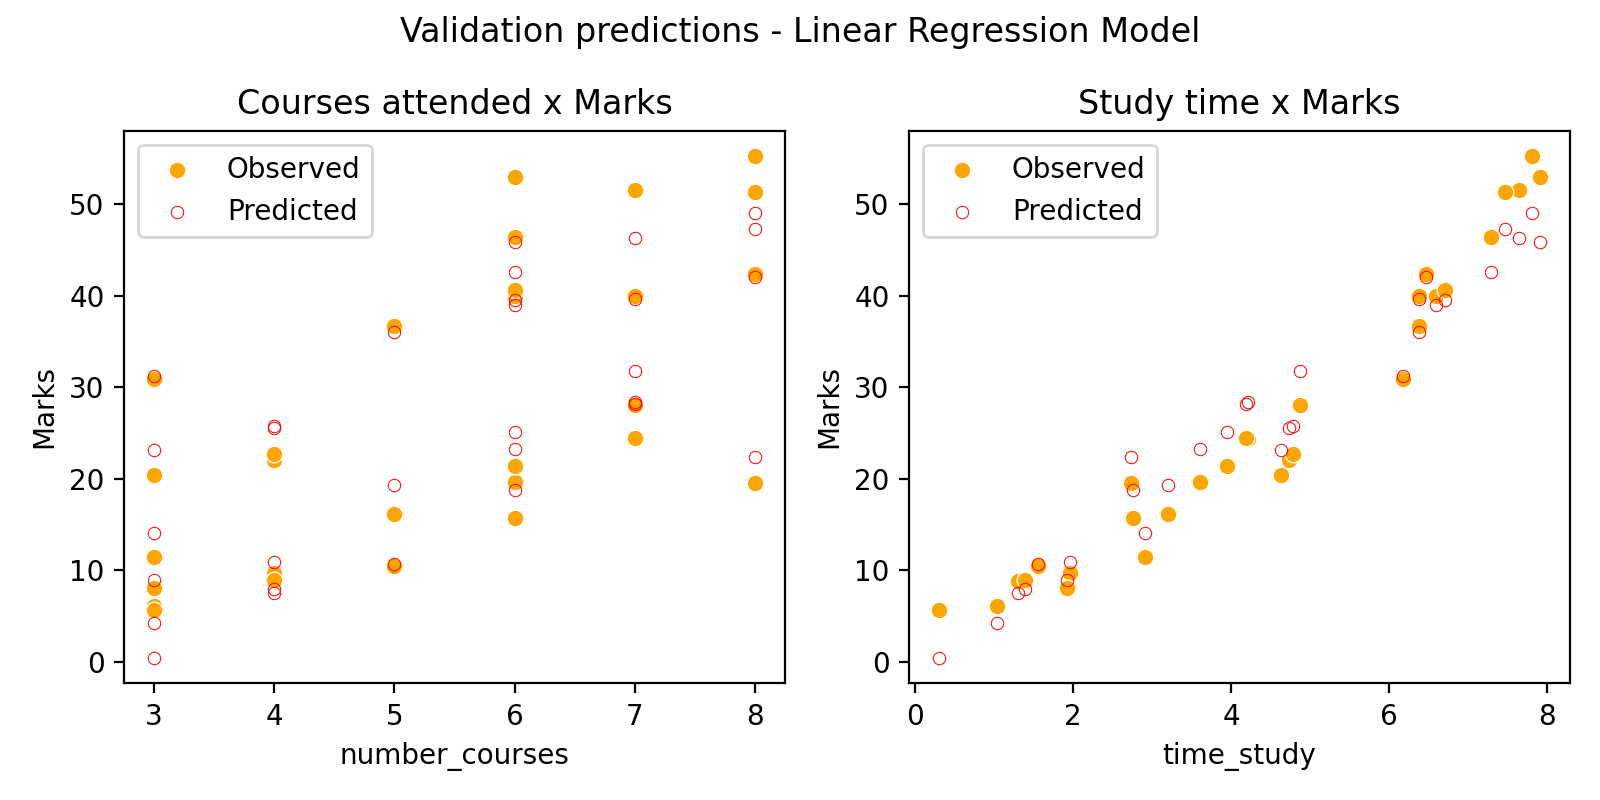

In [32]:
# Create a figure with 2 plots
fig = plt.figure(figsize=(8, 4))
specs = gridspec.GridSpec(nrows=1, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])
fig.suptitle('Validation predictions - Linear Regression Model')


# Plot 1
sns.scatterplot(ax=ax1, data=df_valid, 
                x='number_courses', y='Marks', 
                c='orange', label='Observed')
sns.scatterplot(ax=ax1, data=df_valid, 
                x='number_courses', y='y_lr', 
                facecolor=(0,0,0,0), s=20, edgecolor='red', label='Predicted')
ax1.set_title('Courses attended x Marks');



# Plot 2
sns.scatterplot(ax=ax2, data=df_valid, 
                x='time_study', y='Marks',
                c='orange', label='Observed')
sns.scatterplot(ax=ax2, data=df_valid, 
                x='time_study', y='y_lr', 
                facecolor=(0,0,0,0), s=20, edgecolor='red',label='Predicted')

ax2.set_title('Study time x Marks');
plt.legend()

plt.tight_layout();

**Notes:** In the plots above, we can compare the observed x predicted values for each feature.

### Decision Tree Regression

Decision Trees are powefull tools for capturing data characteristics. If we do not impose constraints to the tree, it overfits to the training data and performs poorly with the validation set. The <i>tree depth</i> is a good parameter for setting in order to avoid overfitting and leave room for generalizing for new cases.<br>

The strategy here was to test a set of possible "max_depth" and get the model with adequate validation performance.


In [33]:
# Parameter optimization - max_depth
train_error = []
valid_error = []
depths = range(1, 10)

for max_depth in depths:
    model_1 = DecisionTreeRegressor(max_depth=max_depth,
                                    criterion='absolute_error',
                                    random_state=15)
    
    model_1.fit(X_train, y_train)
    train_error.append(mean_absolute_error(y_train, model_1.predict(X_train)))
    valid_error.append(mean_absolute_error(y_valid, model_1.predict(X_valid)))

plt.figure(figsize=(5, 4))
plt.plot(depths, train_error, label='Training error',
         color='green', marker='o', markersize=3)
plt.plot(depths, valid_error, label='Validation error',
         color='orange',marker='o',markersize=3)

plt.title('Parameter optimization', pad=15, size=12)
plt.xlabel('Tree depth')
plt.ylabel('Mean absolute error')

plt.legend()
plt.show()
plt.savefig('dt_optimization.png')

<IPython.core.display.Javascript object>

**Note:** Tree depth 3 has a good relationship between training and validation errors; from depth 3 to 4, we observe a little decrement in validation error with a higher decrement in training error, indicating that the model is overfitting to the training data.

The chosen model is implemented below, using the absolute error as the criterion for splitting the tree's nodes.

In [34]:
# Create and fit the model that produced the minimum MAE
dt_model = DecisionTreeRegressor(max_depth=3,
                                 criterion='absolute_error',
                                 random_state=15)
dt_model.fit(X_train, y_train)

# Generate predictions for the validation set
df_valid['y_dt'] = dt_model.predict(X_valid)

In [35]:
# Compute MAE - Train and Valid
mae_train_dt_model = mean_absolute_error(y_train, dt_model.predict(X_train))
mae_valid_dt_model = mean_absolute_error(y_valid, df_valid['y_dt'])

# Log in the DF
df_models.loc['Decision Tree Model', 'Error (Train)'] = mae_train_dt_model
df_models.loc['Decision Tree Model', 'Error (Validation)'] = mae_valid_dt_model

# Compute the decrease % and display df_models
df_models['Valid. Error Decrease (%)'] = df_models['Error (Validation)'].pct_change() * 100

display( df_models.iloc[:3].round(2) )

Error (Train)  Error (Validation)  \
Mean Model                       11.35               12.85   
Linear Regression Model           3.19                2.73   
Decision Tree Model               1.99                2.36   

                         Valid. Error Decrease (%)  
Mean Model                                     NaN  
Linear Regression Model                     -78.75  
Decision Tree Model                         -13.52

In [36]:
# Generate predictions based on this model 
predictions_dt = dt_model.predict(X_artif)

<IPython.core.display.Javascript object>


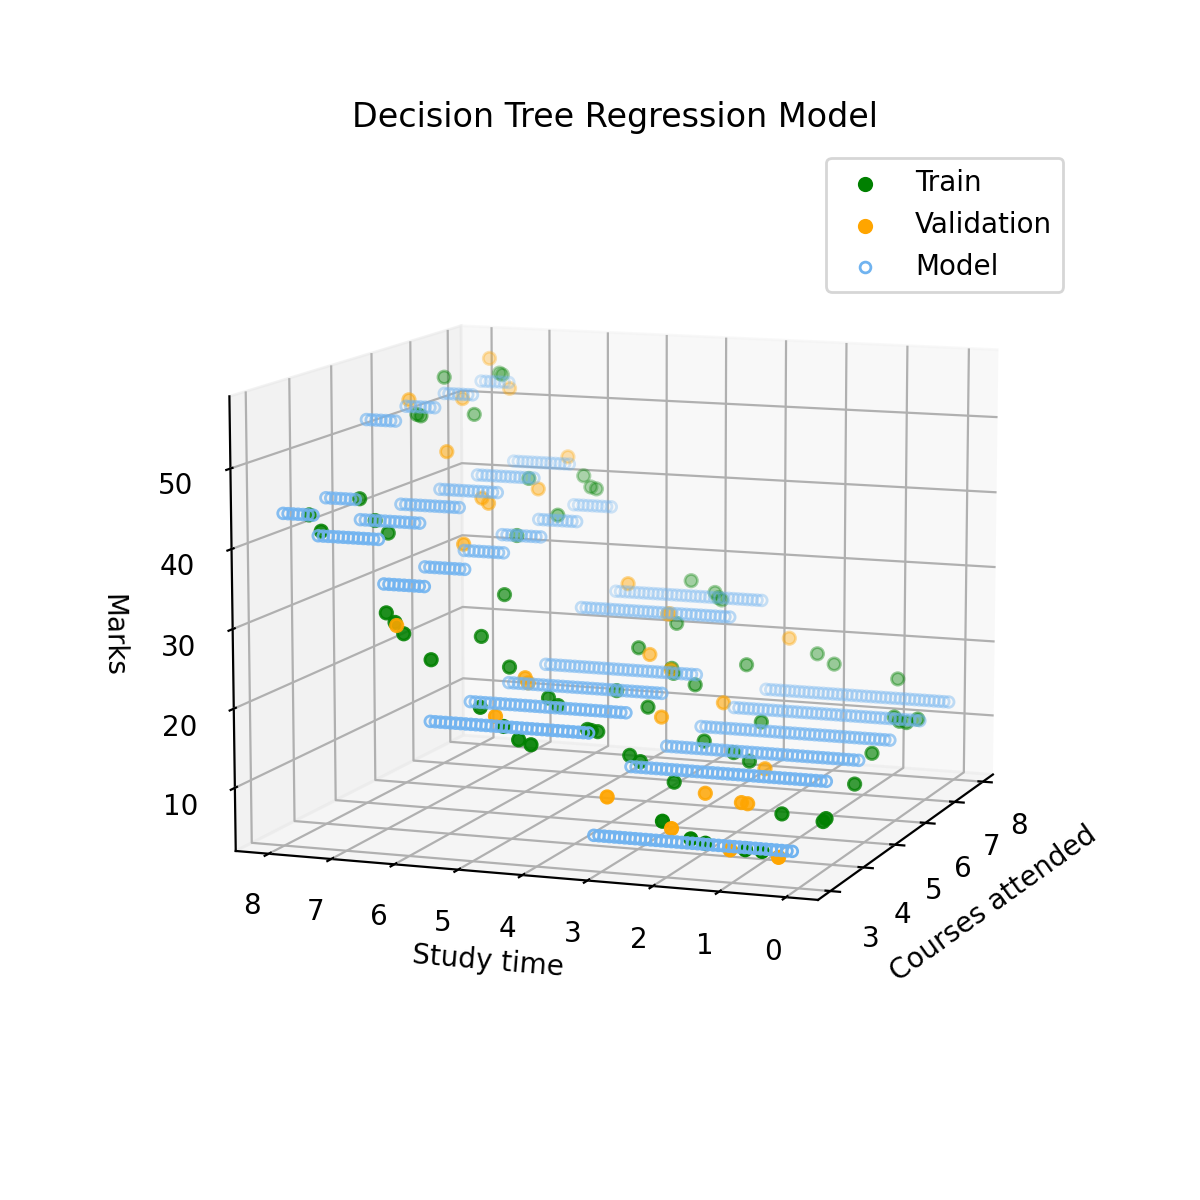

In [37]:
# For plotting editable 3D plot
%matplotlib notebook

# Create figure for 3D projection
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')

# Scatter plot of the training data
x1_t = X_train['number_courses'] # x1
x2_t = X_train['time_study']     # x2
y_t = y_train                    # y (target)
ax.scatter(x1_t, x2_t, y_t, c='green', label='Train')

# Scatter plot of the validation data
x1_v = X_valid['number_courses'] # x1
x2_v = X_valid['time_study']     # x2
y_v = y_valid                    # y (target)
ax.scatter(x1_v, x2_v, y_v, c='orange', label='Validation')

# Scatter plot of the artificial data
ax.scatter(X_artif['number_courses'], # x
           X_artif['time_study'],     # y
           predictions_dt,               # z
           facecolor=(0,0,0,0), s=15, edgecolor='#70b3f0', label='Model')

# Set title and labels
ax.set_title('Decision Tree Regression Model')
ax.set_xlabel("Courses attended")
ax.set_ylabel("Study time")
ax.set_zlabel("Marks")

# Plot the legend
plt.legend()

# Set the angle of the camera
ax.view_init(10, 200)
plt.ioff();

**Notes:**
- In the plot above, we see how the decision tree regression looks like. It is able to capture part of the nonlinearity by "breaking" the predictions in the space for best summarizing subsets of the data.
- Nevertheless, the average error is around 2 units for both the training and validation sets.

In the plots below, we see the model's predictions against the observed values.

In [38]:
# For plotting editable 3D plot
%matplotlib notebook
plt.ion()

# Create figure for 3D projection
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')


# Scatter plot of the validation data
x1_v = df_valid['number_courses'] # x1
x2_v = df_valid['time_study']     # x2
y_v = df_valid['Marks']           # y (target)
ax.scatter(x1_v, x2_v, y_v, c='orange', label='Observed')

# Scatter plot of the predicted data
ax.scatter(df_valid['number_courses'], # x
           df_valid['time_study'],     # y
           df_valid['y_lr'],           # z
           facecolor=(0,0,0,0), edgecolor='red', label='Predicted')

# Set title and labels
ax.set_title(f'Validation - Decision Tree Regression\
\nMean Absolute Error: {mae_valid_dt_model:.2f}')
ax.set_xlabel("Courses attended")
ax.set_ylabel("Study time")
ax.set_zlabel("Marks")

# Plot the legend
plt.legend()

# Set the angle of the camera
ax.view_init(10, 190)
plt.ioff();

<IPython.core.display.Javascript object>

In [39]:
# Return to normal plotting
%matplotlib auto
plt.ion();

Using matplotlib backend: nbAgg


In [40]:
# Create a figure with 2 plots
fig = plt.figure(figsize=(8, 4))
specs = gridspec.GridSpec(nrows=1, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])
fig.suptitle('Validation predictions - Decision Tree Model')


# Plot 1
sns.scatterplot(ax=ax1, data=df_valid, 
                x='number_courses', y='Marks', 
                c='orange', label='Observed')
sns.scatterplot(ax=ax1, data=df_valid, 
                x='number_courses', y='y_dt', 
                facecolor=(0,0,0,0), s=20, edgecolor='red', label='Predicted')
ax1.set_title('Courses attended x Marks');



# Plot 2
sns.scatterplot(ax=ax2, data=df_valid, 
                x='time_study', y='Marks',
                c='orange', label='Observed')
sns.scatterplot(ax=ax2, data=df_valid, 
                x='time_study', y='y_dt', 
                facecolor=(0,0,0,0), s=20, edgecolor='red', label='Predicted')

ax2.set_title('Study time x Marks');
plt.legend()

plt.tight_layout();

<IPython.core.display.Javascript object>

#### Feature importance

The most important feature was time_study. 

In [41]:
# Create a dictionary of features and their importance values
feat_imp_dict= {}
for col, val in sorted(zip(X_train.columns, dt_model.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_imp_dict[col]=val.round(3) * 100

dt_f_imp = pd.DataFrame({'Feature':feat_imp_dict.keys(),'Importance (%)':feat_imp_dict.values()})

display( dt_f_imp )

Feature  Importance (%)
0      time_study            90.8
1  number_courses             9.2

#### Visualizing the tree

Below, we see nice diagrams showing the model's decisions for splitting the data to minimize the error. The terminal nodes have the predictions for the target variable.

In [42]:
# Returning to normal plotting
%matplotlib auto

Using matplotlib backend: nbAgg


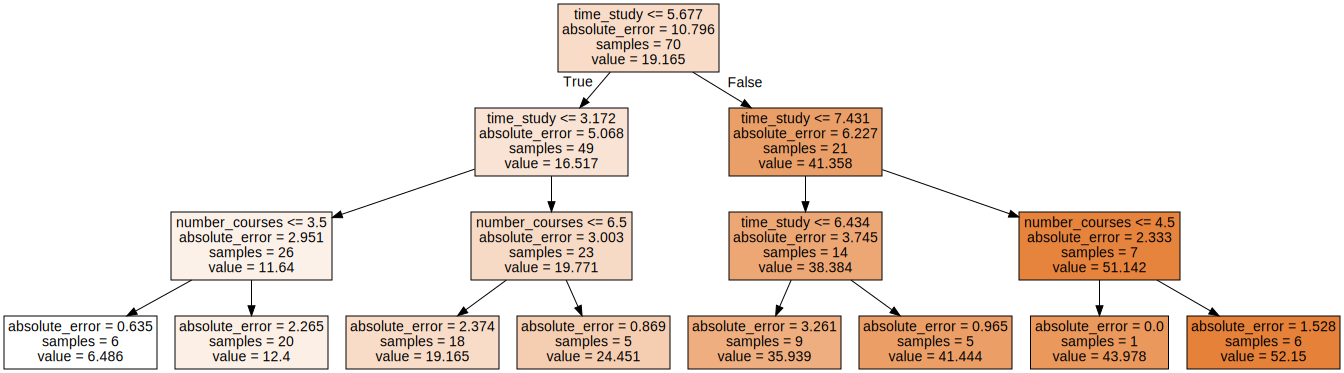

In [43]:
dot_data = export_graphviz(dt_model, out_file=None, 
                                feature_names=dt_model.feature_names_in_,  
                                filled=True)

tree_image = graphviz.Source(dot_data, format="jpg")
tree_image.render(filename='dt_model_image',view = False, format='jpg')

display(graphviz.Source(dot_data, format="svg"))

<br>
<br>
The Figure below is interesting for showing plots of the model's decisions.

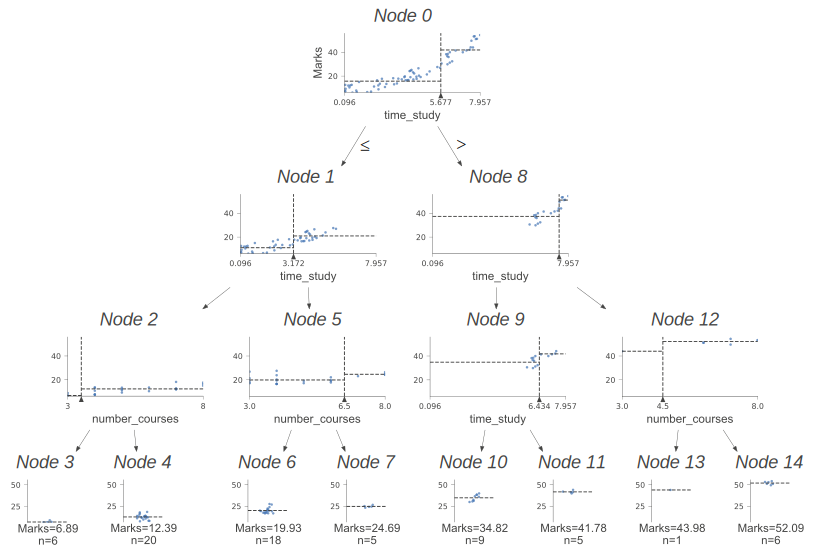

In [44]:
warnings.filterwarnings('ignore')
plt.ioff()
viz = dtreeviz(dt_model, X_train, y_train,
               target_name=y_train.name,
               feature_names=dt_model.feature_names_in_,
               scale=1.3, show_node_labels=True
               )
viz.save("dtreeviz.svg")
display(SVG("dtreeviz.svg"))

<br>
<br>
Another interesting visualization is the textual representation of the model:

In [45]:
text_representation = export_text(dt_model)
print(text_representation)

|--- feature_1 <= 5.68
|   |--- feature_1 <= 3.17
|   |   |--- feature_0 <= 3.50
|   |   |   |--- value: [6.49]
|   |   |--- feature_0 >  3.50
|   |   |   |--- value: [12.40]
|   |--- feature_1 >  3.17
|   |   |--- feature_0 <= 6.50
|   |   |   |--- value: [19.16]
|   |   |--- feature_0 >  6.50
|   |   |   |--- value: [24.45]
|--- feature_1 >  5.68
|   |--- feature_1 <= 7.43
|   |   |--- feature_1 <= 6.43
|   |   |   |--- value: [35.94]
|   |   |--- feature_1 >  6.43
|   |   |   |--- value: [41.44]
|   |--- feature_1 >  7.43
|   |   |--- feature_0 <= 4.50
|   |   |   |--- value: [43.98]
|   |   |--- feature_0 >  4.50
|   |   |   |--- value: [52.15]



### Random Forest Regression

A Random Forest is a collection of random decision trees. The single trees are random in the sense that each one is trained with a random sampling of features and observations, in a way that each tree develops a solution to the part of the data observed. The forest then combines the output of the several decision trees to reach a solution. In this way, this model reduces the risk of overfitting and increases the flexibility of predictions.

One of the main parameters we have to adjust in a Random Forest is the number of decision trees, the "n_estimators". The test of different parameters is shown below.

In [46]:
# Adjust plotting
%matplotlib auto
plt.ion();

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


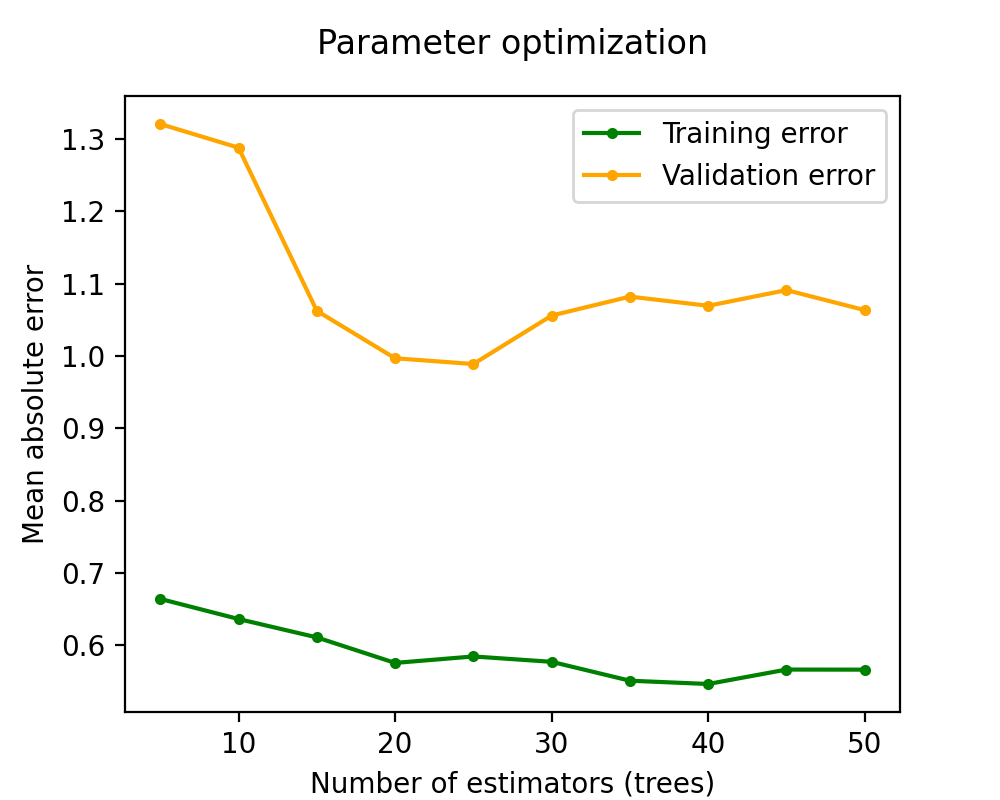

In [47]:
# Optimization of the n_estimators parameter
train_error = []
valid_error = []
n_estimators = np.arange(0,55, 5)[1:]

for n_estimator in n_estimators:
    model_rf = RandomForestRegressor(n_estimators=n_estimator,
                                    criterion='absolute_error',
                                    #max_depth=3,
                                    random_state=15)
    
    model_rf.fit(X_train, y_train)
    train_error.append(mean_absolute_error(y_train, model_rf.predict(X_train)))
    valid_error.append(mean_absolute_error(y_valid, model_rf.predict(X_valid)))

plt.figure(figsize=(5, 4))
plt.plot(n_estimators, train_error, label='Training error',
         color='green', marker='o', markersize=3)
plt.plot(n_estimators, valid_error, label='Validation error',
         color='orange',marker='o',markersize=3)

plt.title('Parameter optimization', pad=15, size=12)
plt.xlabel('Number of estimators (trees)')
plt.ylabel('Mean absolute error')

plt.legend();
#plt.show()
plt.savefig('rf_optimization.png')

#### Finding the best parameter

In [48]:
# Convert lists to numpy arrays
train_error = np.array(train_error)
valid_error = np.array(valid_error)

# Get and identify min difference
min_diff = (valid_error-train_error).min()
min_diff_idx = (valid_error-train_error).argmin()
best_n_estimator = n_estimators[min_diff_idx]
print(f'Minimum train-validation distance was {min_diff:.2f} in index {min_diff_idx},\
 with n_estimators = {best_n_estimator}.')

Minimum train-validation distance was 0.40 in index 4, with n_estimators = 25.


<br>
The model is implemented below, with the absolute error as the criterion for minimizing the error. 

In [49]:
# Create and fit the model that produced the minimum MAE
rf_model = model = RandomForestRegressor(n_estimators=best_n_estimator,
                                         criterion='absolute_error',
                                         random_state=15)
rf_model.fit(X_train, y_train)
# Generate predicions for the validation set
df_valid['y_rf'] = rf_model.predict(X_valid)

In [50]:
# Compute MAE - Train and Valid
mae_train_rf_model = mean_absolute_error(y_train, rf_model.predict(X_train))
mae_valid_rf_model = mean_absolute_error(y_valid, df_valid['y_rf'])

# Log in the DF
df_models.loc['Random Forest Model', 'Error (Train)'] = mae_train_rf_model
df_models.loc['Random Forest Model', 'Error (Validation)'] = mae_valid_rf_model

# Compute the decrease % and display df_models
df_models['Valid. Error Decrease (%)'] = df_models['Error (Validation)'].pct_change() * 100
display( df_models.round(2) )

Error (Train)  Error (Validation)  \
Mean Model                       11.35               12.85   
Linear Regression Model           3.19                2.73   
Decision Tree Model               1.99                2.36   
Random Forest Model               0.58                0.99   

                         Valid. Error Decrease (%)  
Mean Model                                     NaN  
Linear Regression Model                     -78.75  
Decision Tree Model                         -13.52  
Random Forest Model                         -58.13

In [51]:
rf_val_error = df_models.loc['Random Forest Model', 'Error (Validation)']
lr_val_error = df_models.loc['Linear Regression Model', 'Error (Validation)']

rf_x_lr = 100 * round(rf_val_error/lr_val_error - 1, 4)

print(f'From Linear Regression to Random Forest, the validation error change was {rf_x_lr}%.')

From Linear Regression to Random Forest, the validation error change was -63.79%.


In [52]:
# Generate predictions based on this model
predictions_rf = rf_model.predict(X_artif)

<IPython.core.display.Javascript object>


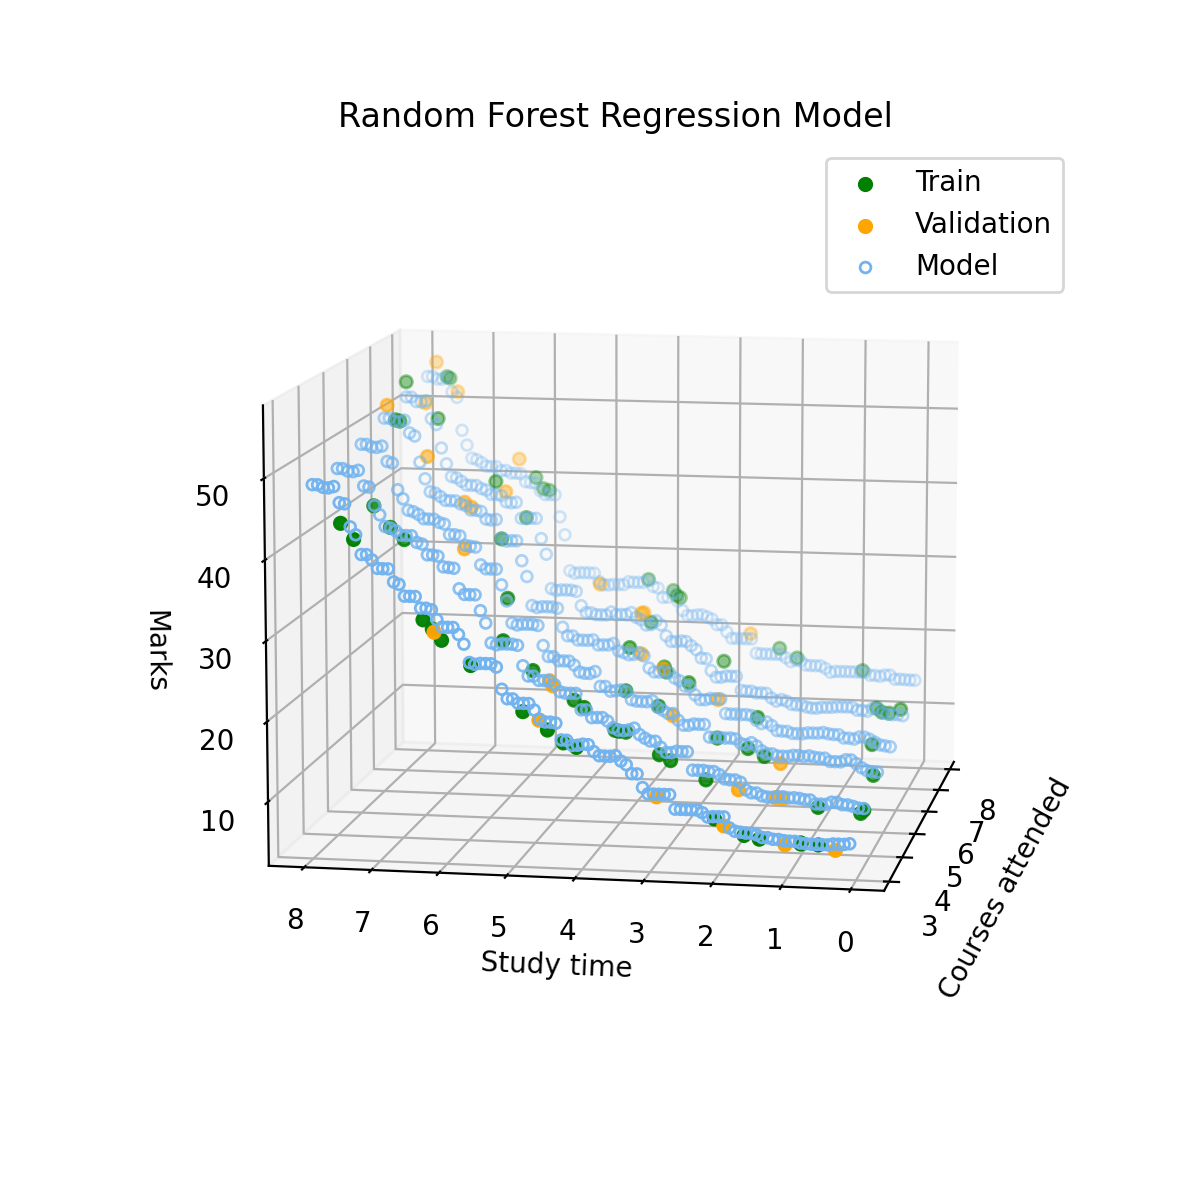

In [53]:
# For plotting editable 3D plot
%matplotlib notebook

# Create figure for 3D projection
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')

# Scatter plot of the training data
x1_t = X_train['number_courses'] # x1
x2_t = X_train['time_study']     # x2
y_t = y_train                    # y (target)
ax.scatter(x1_t, x2_t, y_t, c='green', label='Train')

# Scatter plot of the validation data
x1_v = X_valid['number_courses'] # x1
x2_v = X_valid['time_study']     # x2
y_v = y_valid                    # y (target)
ax.scatter(x1_v, x2_v, y_v, c='orange', label='Validation')

# Scatter plot of the artificial data
ax.scatter(X_artif['number_courses'], # x
           X_artif['time_study'],     # y
           predictions_rf,               # z
           facecolor=(0,0,0,0), s=15, edgecolor='#70b3f0', label='Model')

# Set title and labels
ax.set_title('Random Forest Regression Model')
ax.set_xlabel("Courses attended")
ax.set_ylabel("Study time")
ax.set_zlabel("Marks")

# Plot the legend
plt.legend()

# Set the angle of the camera
ax.view_init(10, 190)


**Notes:**
- The Random Forest model was the best model for capturing the nonlinearity of the data. 
- The validation performance represented a 58.1% decrease in error in comparison to the Decision Tree regression, and a 63.8% decrease in error in comparison to the Linear Regression. 
- The predictions deviated in average 1 point from the real Marks, being a much more precise model than the Decision Tree and the Linear Regression. 
- Given the higher number of estimators, the Random Forest is able to "break" the predictions is smaller parts, generating a higher range of predicted values.

Below, we see the comparisons between the observed and predicted values.

<IPython.core.display.Javascript object>


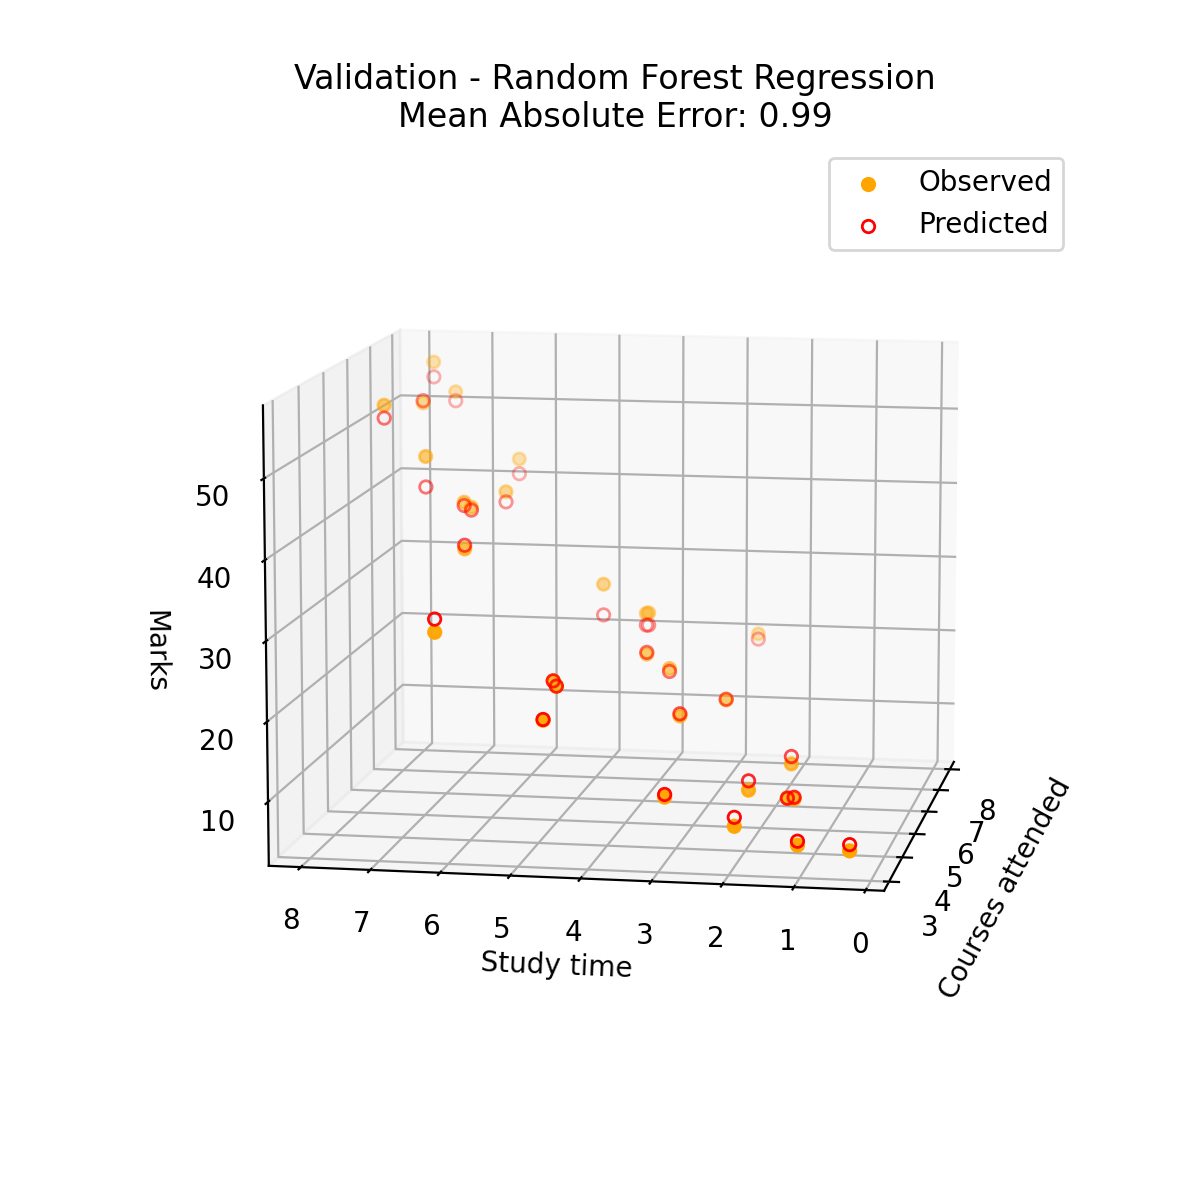

In [54]:
# Create figure for 3D projection
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')


# Scatter plot of the validation data
x1_v = df_valid['number_courses'] # x1
x2_v = df_valid['time_study']     # x2
y_v = df_valid['Marks']           # y (target)
ax.scatter(x1_v, x2_v, y_v, c='orange', label='Observed')

# Scatter plot of the predicted data
ax.scatter(df_valid['number_courses'], # x
           df_valid['time_study'],     # y
           df_valid['y_rf'],           # z
           facecolor=(0,0,0,0), edgecolor='red', label='Predicted')

# Set title and labels
ax.set_title(f'Validation - Random Forest Regression\
\nMean Absolute Error: {mae_valid_rf_model:.2f}')
ax.set_xlabel("Courses attended")
ax.set_ylabel("Study time")
ax.set_zlabel("Marks")

# Plot the legend
plt.legend()

# Set the angle of the camera
ax.view_init(10, 190)
plt.ioff();

In [55]:
# Return to normal plotting
%matplotlib auto
plt.ion();

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


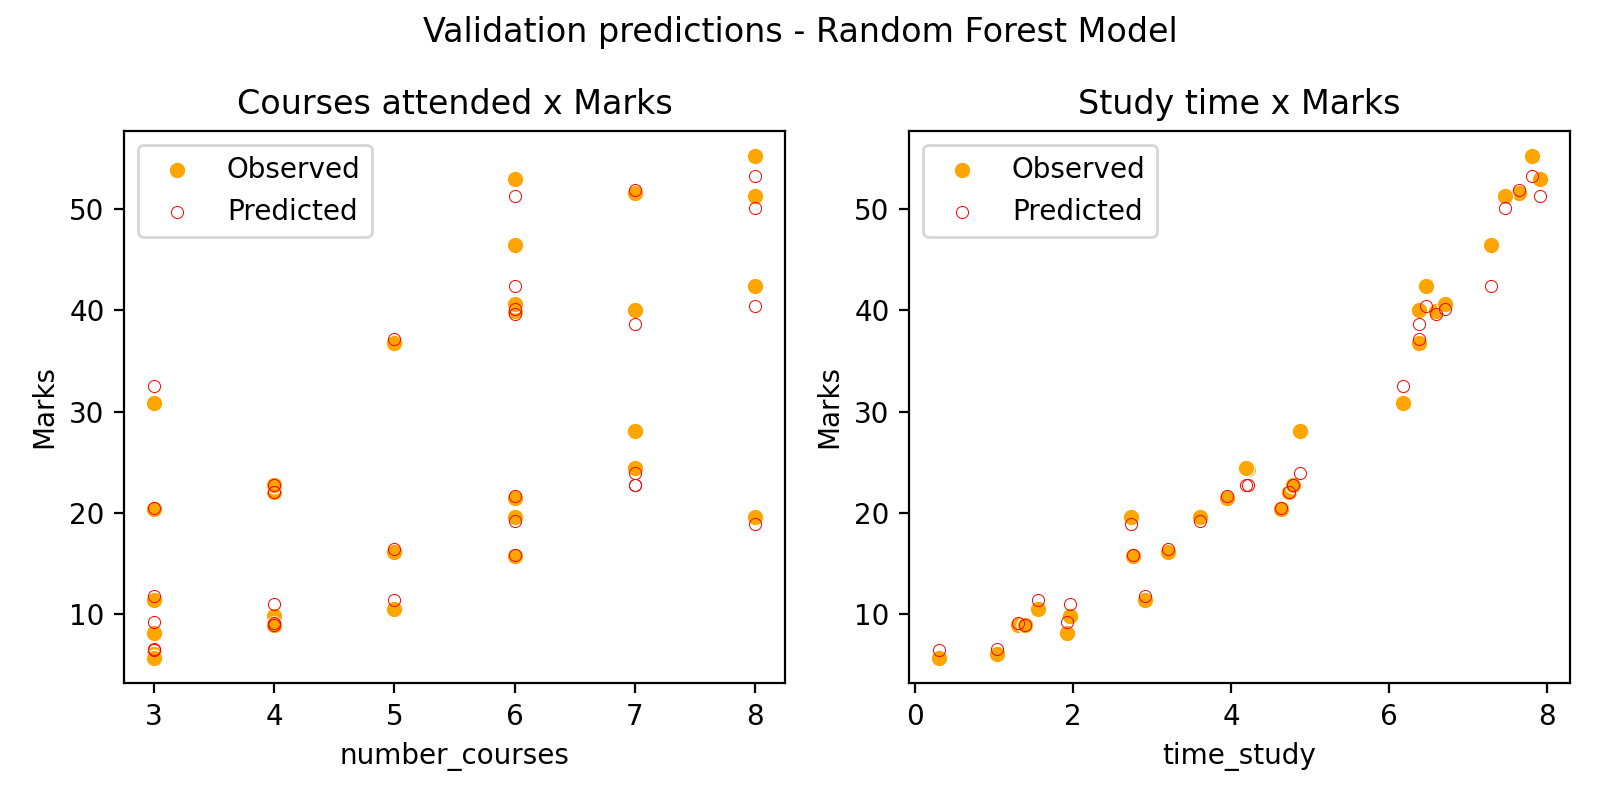

In [56]:
# Create a figure with 2 plots
fig = plt.figure(figsize=(8, 4))
specs = gridspec.GridSpec(nrows=1, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])
fig.suptitle('Validation predictions - Random Forest Model')


# Plot 1
sns.scatterplot(ax=ax1, data=df_valid, 
                x='number_courses', y='Marks', 
                c='orange', label='Observed')
sns.scatterplot(ax=ax1, data=df_valid, 
                x='number_courses', y='y_rf', 
                facecolor=(0,0,0,0), s=19,edgecolor='red', label='Predicted')
ax1.set_title('Courses attended x Marks');



# Plot 2
sns.scatterplot(ax=ax2, data=df_valid, 
                x='time_study', y='Marks',
                c='orange', label='Observed')
sns.scatterplot(ax=ax2, data=df_valid, 
                x='time_study', y='y_rf', 
                facecolor=(0,0,0,0),s=19, edgecolor='red', label='Predicted')

ax2.set_title('Study time x Marks');
plt.legend()

plt.tight_layout();

#### Feature importance

The feature time_study was the most important, and in this case the number_courses had a higher importance than for the Decision Tree model.

In [57]:
# Create a dictionary of features and their importance values
feat_imp_dict= {}
for col, val in sorted(zip(X_train.columns, rf_model.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_imp_dict[col]=val.round(3) * 100

rf_f_imp = pd.DataFrame({'Feature':feat_imp_dict.keys(),'Importance (%)':feat_imp_dict.values()})

display( rf_f_imp )

Feature  Importance (%)
0      time_study            87.2
1  number_courses            12.8

### Summary

This is the summary of results. <br>

In [58]:
display( df_models.round(2) )

Error (Train)  Error (Validation)  \
Mean Model                       11.35               12.85   
Linear Regression Model           3.19                2.73   
Decision Tree Model               1.99                2.36   
Random Forest Model               0.58                0.99   

                         Valid. Error Decrease (%)  
Mean Model                                     NaN  
Linear Regression Model                     -78.75  
Decision Tree Model                         -13.52  
Random Forest Model                         -58.13

### Validation Results

In the table below, we can visually observe and compare the students' Marks and the models' predictions.

y_lr: predictions of the Linear Regression<br>
y_dt: predictions of the Decision Tree<br>
y_rf: predictions of the Random Forest.

In [59]:
display( df_valid.drop('y_mean', axis=1).round(3) )

number_courses  time_study   Marks    y_lr    y_dt    y_rf
37               6       7.283  46.453  42.600  41.444  42.462
62               6       3.606  19.590  23.280  19.165  19.207
83               5       3.197  16.106  19.291  19.165  16.385
14               3       2.908  11.397  14.091   6.486  11.723
43               5       1.557  10.429  10.674  12.400  11.384
9                3       6.173  30.862  31.246  35.939  32.491
44               4       1.954   9.742  10.919  12.400  10.917
31               3       1.923   8.100   8.916   6.486   9.212
69               6       3.948  21.400  25.077  19.165  21.627
57               7       7.649  51.583  46.363  52.150  51.886
33               6       6.594  39.965  38.980  41.444  39.598
87               3       1.033   6.053   4.240   6.486   6.552
12               7       4.218  24.318  28.337  24.451  22.751
91               8       2.730  19.564  22.359  12.400  18.860
41               6       2.754  15.725  18.804  12.400  15.811
23               7       4.875  28.043  31.789  24.451  23.929
76               5       6.379  36.746  36.009  35.939  37.211
29               4       1.299   8.837   7.478  12.400   9.056
50               6       6.703  40.602  39.552  41.444  40.170
68               4       1.395   8.920   7.982  12.400   8.905
3                6       7.909  53.018  45.889  52.150  51.331
4                8       7.811  55.299  49.055  52.150  53.282
90               7       4.182  24.394  28.148  24.451  22.751
72               3       4.633  20.398  23.154  19.165  20.492
20               4       4.733  22.073  25.521  19.165  22.039
59               8       7.468  51.343  47.253  52.150  50.116
93               8       6.471  42.426  42.015  41.444  40.428
96               3       0.301   5.609   0.394   6.486   6.379
89               7       6.376  40.024  39.675  35.939  38.674
47               4       4.779  22.701  25.762  19.165  22.702

#### Observed x Predicted plots

The plots below show the scatterplot for comparing the observed values with the predicted values of each model. The diagonal red line indicates the set of points in which the predictions are equal to the observed values.

<IPython.core.display.Javascript object>


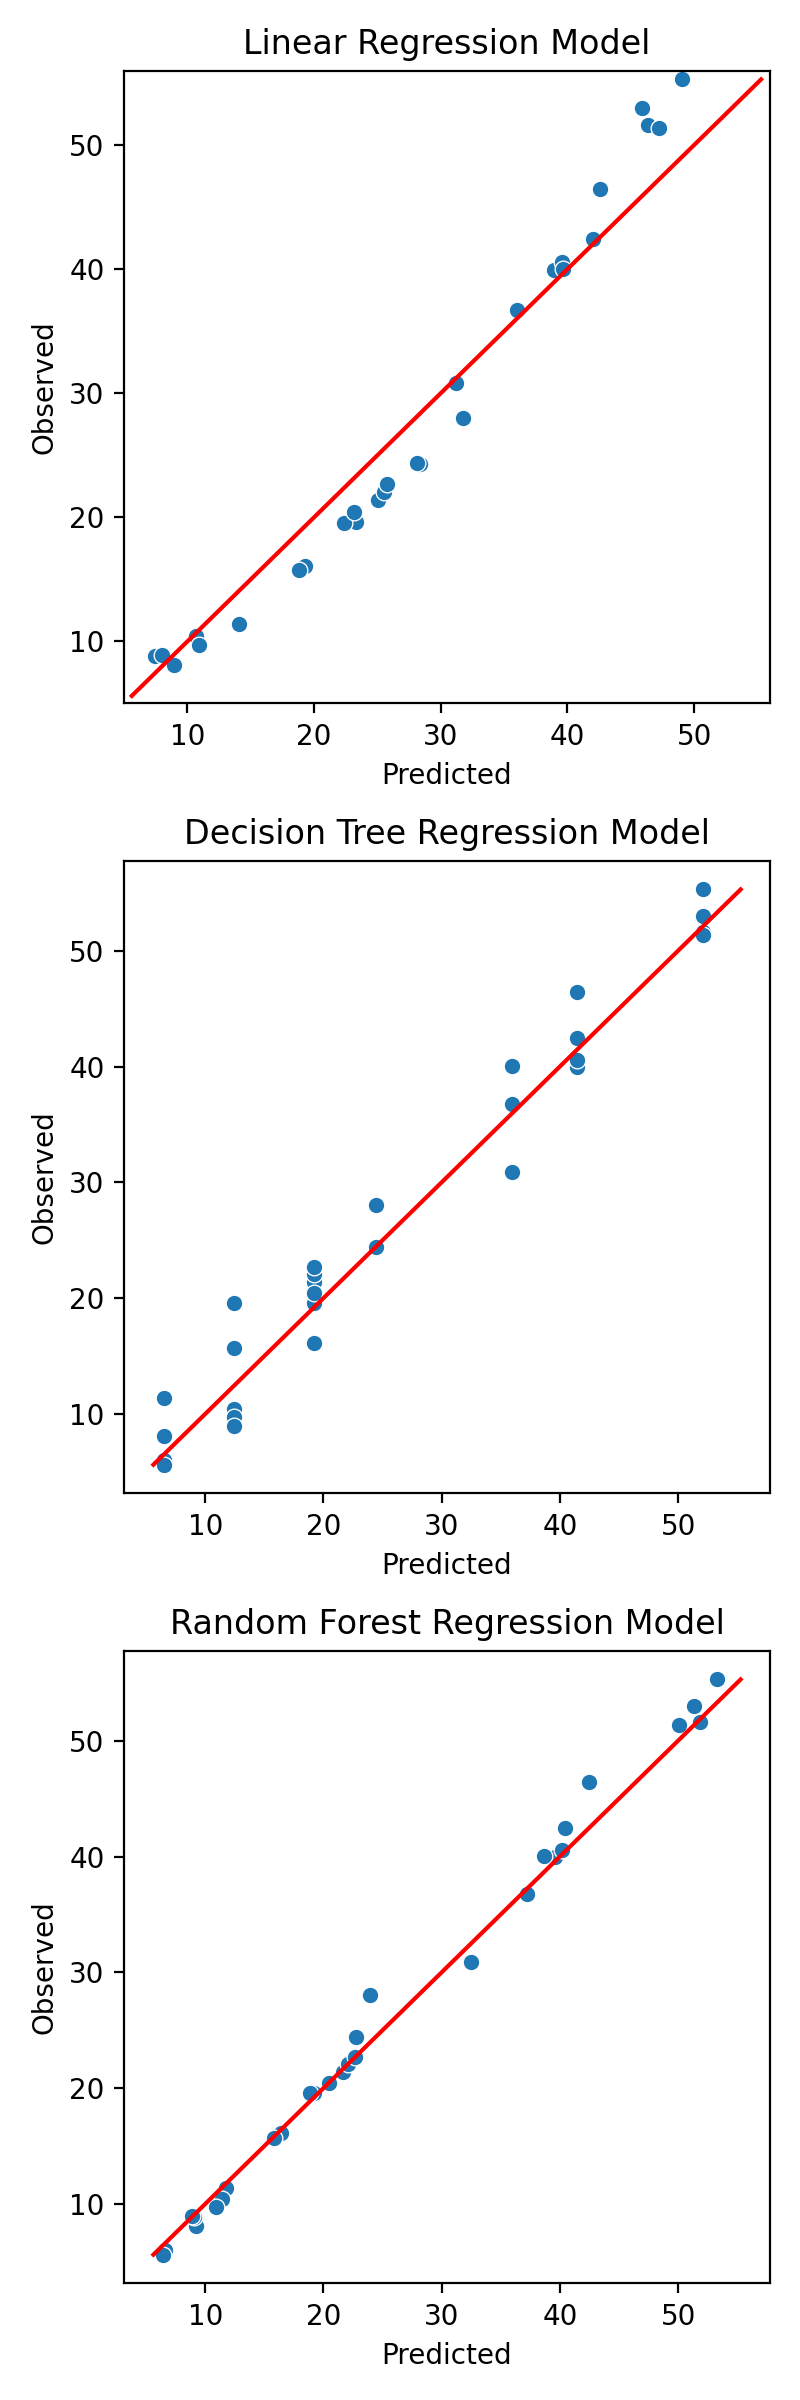

In [60]:
# For defining the axes limits
min_mark = np.int(df['Marks'].min())
max_mark = np.int(df['Marks'].max() + 1)


# Create a figure with 3 plots
fig = plt.figure(figsize=(4, 12))
specs = gridspec.GridSpec(nrows=3, ncols=1 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[1, 0])
ax3 = fig.add_subplot(specs[2, 0])
#fig.suptitle('Observed x Predicted for each model')


sns.lineplot(ax=ax1, data=df_valid, 
                x='Marks', y='Marks',markers='--',c='r')
sns.lineplot(ax=ax2, data=df_valid, 
                x='Marks', y='Marks',markers='--',c='r')
sns.lineplot(ax=ax3, data=df_valid, 
                x='Marks', y='Marks',markers='--',c='r')



sns.scatterplot(ax=ax1, data=df_valid, 
                x='y_lr', y='Marks')
ax1.set_title('Linear Regression Model')
ax1.set_ylabel('Observed')
ax1.set_xlabel('Predicted')
ax1.set_xlim(min_mark,max_mark)
ax1.set_ylim(min_mark,max_mark)

sns.scatterplot(ax=ax2, data=df_valid,
                x='y_dt', y='Marks')
ax2.set_title('Decision Tree Regression Model')
ax2.set_ylabel('Observed')
ax2.set_xlabel('Predicted')

sns.scatterplot(ax=ax3, data=df_valid, 
                x='y_rf', y='Marks')
ax3.set_title('Random Forest Regression Model')
ax3.set_ylabel('Observed')
ax3.set_xlabel('Predicted')

plt.tight_layout();

## Concluding remarks

I've chosen a simple, small problem because my main purpose was to investigate how regressions look like when we use Decision Trees and Random Forests.<br>

The three-dimensional visualizations, together with the range of predictions produced by the models to the artificial dataset, have helped me gaining a deeper understanding of how these models work and solve problems. <br>

Looking at the plots, it is clear the advantages of the Random Forest in comparison to Decision Trees and Linear Regressions. <br>

My next steps involve exploring more complex regression problems and a broader range of ensemble models, that is, models composed by a set of minor estimators, like the Random Forest.